# Genrealized bayesian network model
In reference Big Five model we assumed that anwser were sampled from repeated Bernoulli process. This assumption allowed for clear probabilistical interpretation of traits. Second assumption was that each trait only affets staments from the group that was desiged to extract this trait. In generalized model (later referenced as proposed model) we remove these assumptions.

![](images/5_traits_model_nn.png)

## Distributions
Trait, similary to first model, will be drawn from Beta distribution. 

\begin{equation}
Trait_i \sim Beta(\alpha=\alpha_{i}, \beta = \beta_{i})
\end{equation}

The difference between this model and fixed model presented before, is that Questions will be drawn from categorical distribution. Probs of that distribution will be a deterministic function of Traits

\begin{equation}
Question_i \sim Categorical(f(Traits ;\Phi)) + 1
\end{equation}

Where $f(Traits; \Phi)$ will be a general function parametrized by $\Phi$. In our project, we represented \(f(Traits; \Phi)\) as neural network with one hidden layer, where \(\Phi\) are the weights of the neural network. As previously, map 0-4 range into desired 1-to-5 range by adding one to sampled values.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import pyro.distributions as dist
from src.common import N_COUNTIRES, load_joint, empty_df, positive_correlation, QUESTIONS, load_train_test
from src.BaseModel import BaseModel
from sklearn.preprocessing import OrdinalEncoder
import torch.distributions.constraints as const
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
from torch import nn
import pyro.distributions.constraints as const
from src.TrainedTraits import FCModel
import inspect
from scipy.stats import entropy, mode
from sortedcontainers import SortedDict
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train, test = load_train_test()

## Model training / loading
Change TRAIN to True in order to train model from scratch. Be wary - as nothing restrics latents to infer any meaning, diffrent repesentation of latent variables might be generated (at very least their order might change).

In [3]:
# Change to true if you want to train the model. However keep in mind, that model might learn diffrent latent variables, based on NN weight initializations
TRAIN = False

model = None
if TRAIN:
    model = FCModel(None)
    model.observe(data=data)
    model.infer(num_steps = 3_000, train=True)
    torch.save(model._decoder.state_dict(), "models/custom_traits.model")
else:
    model = FCModel(None, pretrained_decoder_path="models/custom_traits.model")

## Analisis of traits on survey made on friends
We created a survey based on questions from dataset, completed it ourselves and gave it to one neurotic friend. The main goal of this is to check the distribution of latents on a small sample of well-known people

If you want to support our reseach you can do test we prepered on your own:
https://forms.gle/GSj6cnxcTtWuhHav6

In [4]:
data_survey = pd.read_csv("dataset/test_results.csv")

users = {}
for _, row in data_survey.iterrows():
    name = row[1]
    users[name] = {
        key: row.values[2 + i]
        for i, key in enumerate(QUESTIONS.keys())
    }

In [5]:
model.reset_observations()
for user, observations in users.items():
    model.observe(user, observations)
model.infer(num_steps=3_000, train=False)

100%|██████████| 3000/3000 [00:24<00:00, 122.99it/s]


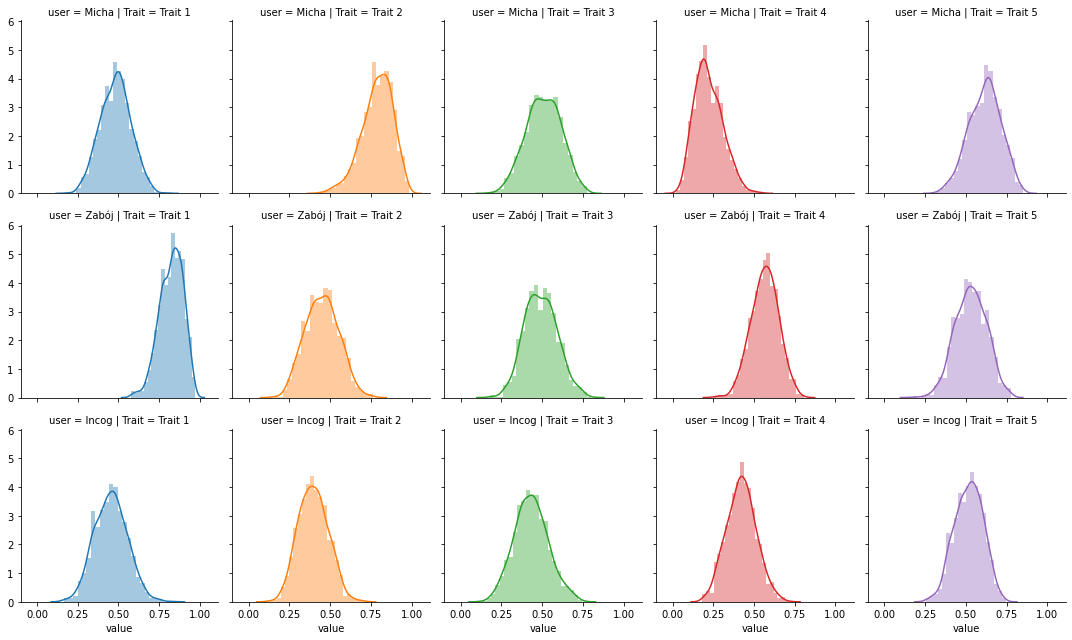

In [6]:
x = model.sample(1000)['trait'].detach().numpy().reshape(1000, 5, -1).transpose([2, 0, 1])

dfs = []
for i, user in enumerate(users.keys()):
    realistations = x[i, :, :]
    
    df = pd.DataFrame( {
        name: realistations[:, i]
        for i, name in enumerate(["Trait 1", "Trait 2", "Trait 3", "Trait 4", "Trait 5"])
    })

    df = pd.melt(df, var_name="Trait")
    df['user'] = user[:5]
    
    dfs.append(df)

data_frame = pd.concat(dfs, ignore_index=True)

g = sns.FacetGrid(data=data_frame, row="user", col="Trait", hue="Trait")
g.map(sns.distplot, "value")

## Variable semantic meaning
This section will focus on resarch into sematnical meaning of latent variables inferred by our model

### Full distribution matrix
The following cell displays posterior anwsers probability distributions when one (normaly latent) trait was observed with given value. Blue bars represent posterior (when trait was observed) and gray represent prior (no values observed) for comparision. We can infer semantical meaning of the variables by comparing posterior with prior, and see on what kind of questions each variable has most effect

In [7]:
def normalized(d):
    keys = np.array(list(d.keys()))
    values = np.array(list(d.values()))
    values = values / np.sum(values)

    return keys, values

100%|██████████| 1000/1000 [00:06<00:00, 159.29it/s]


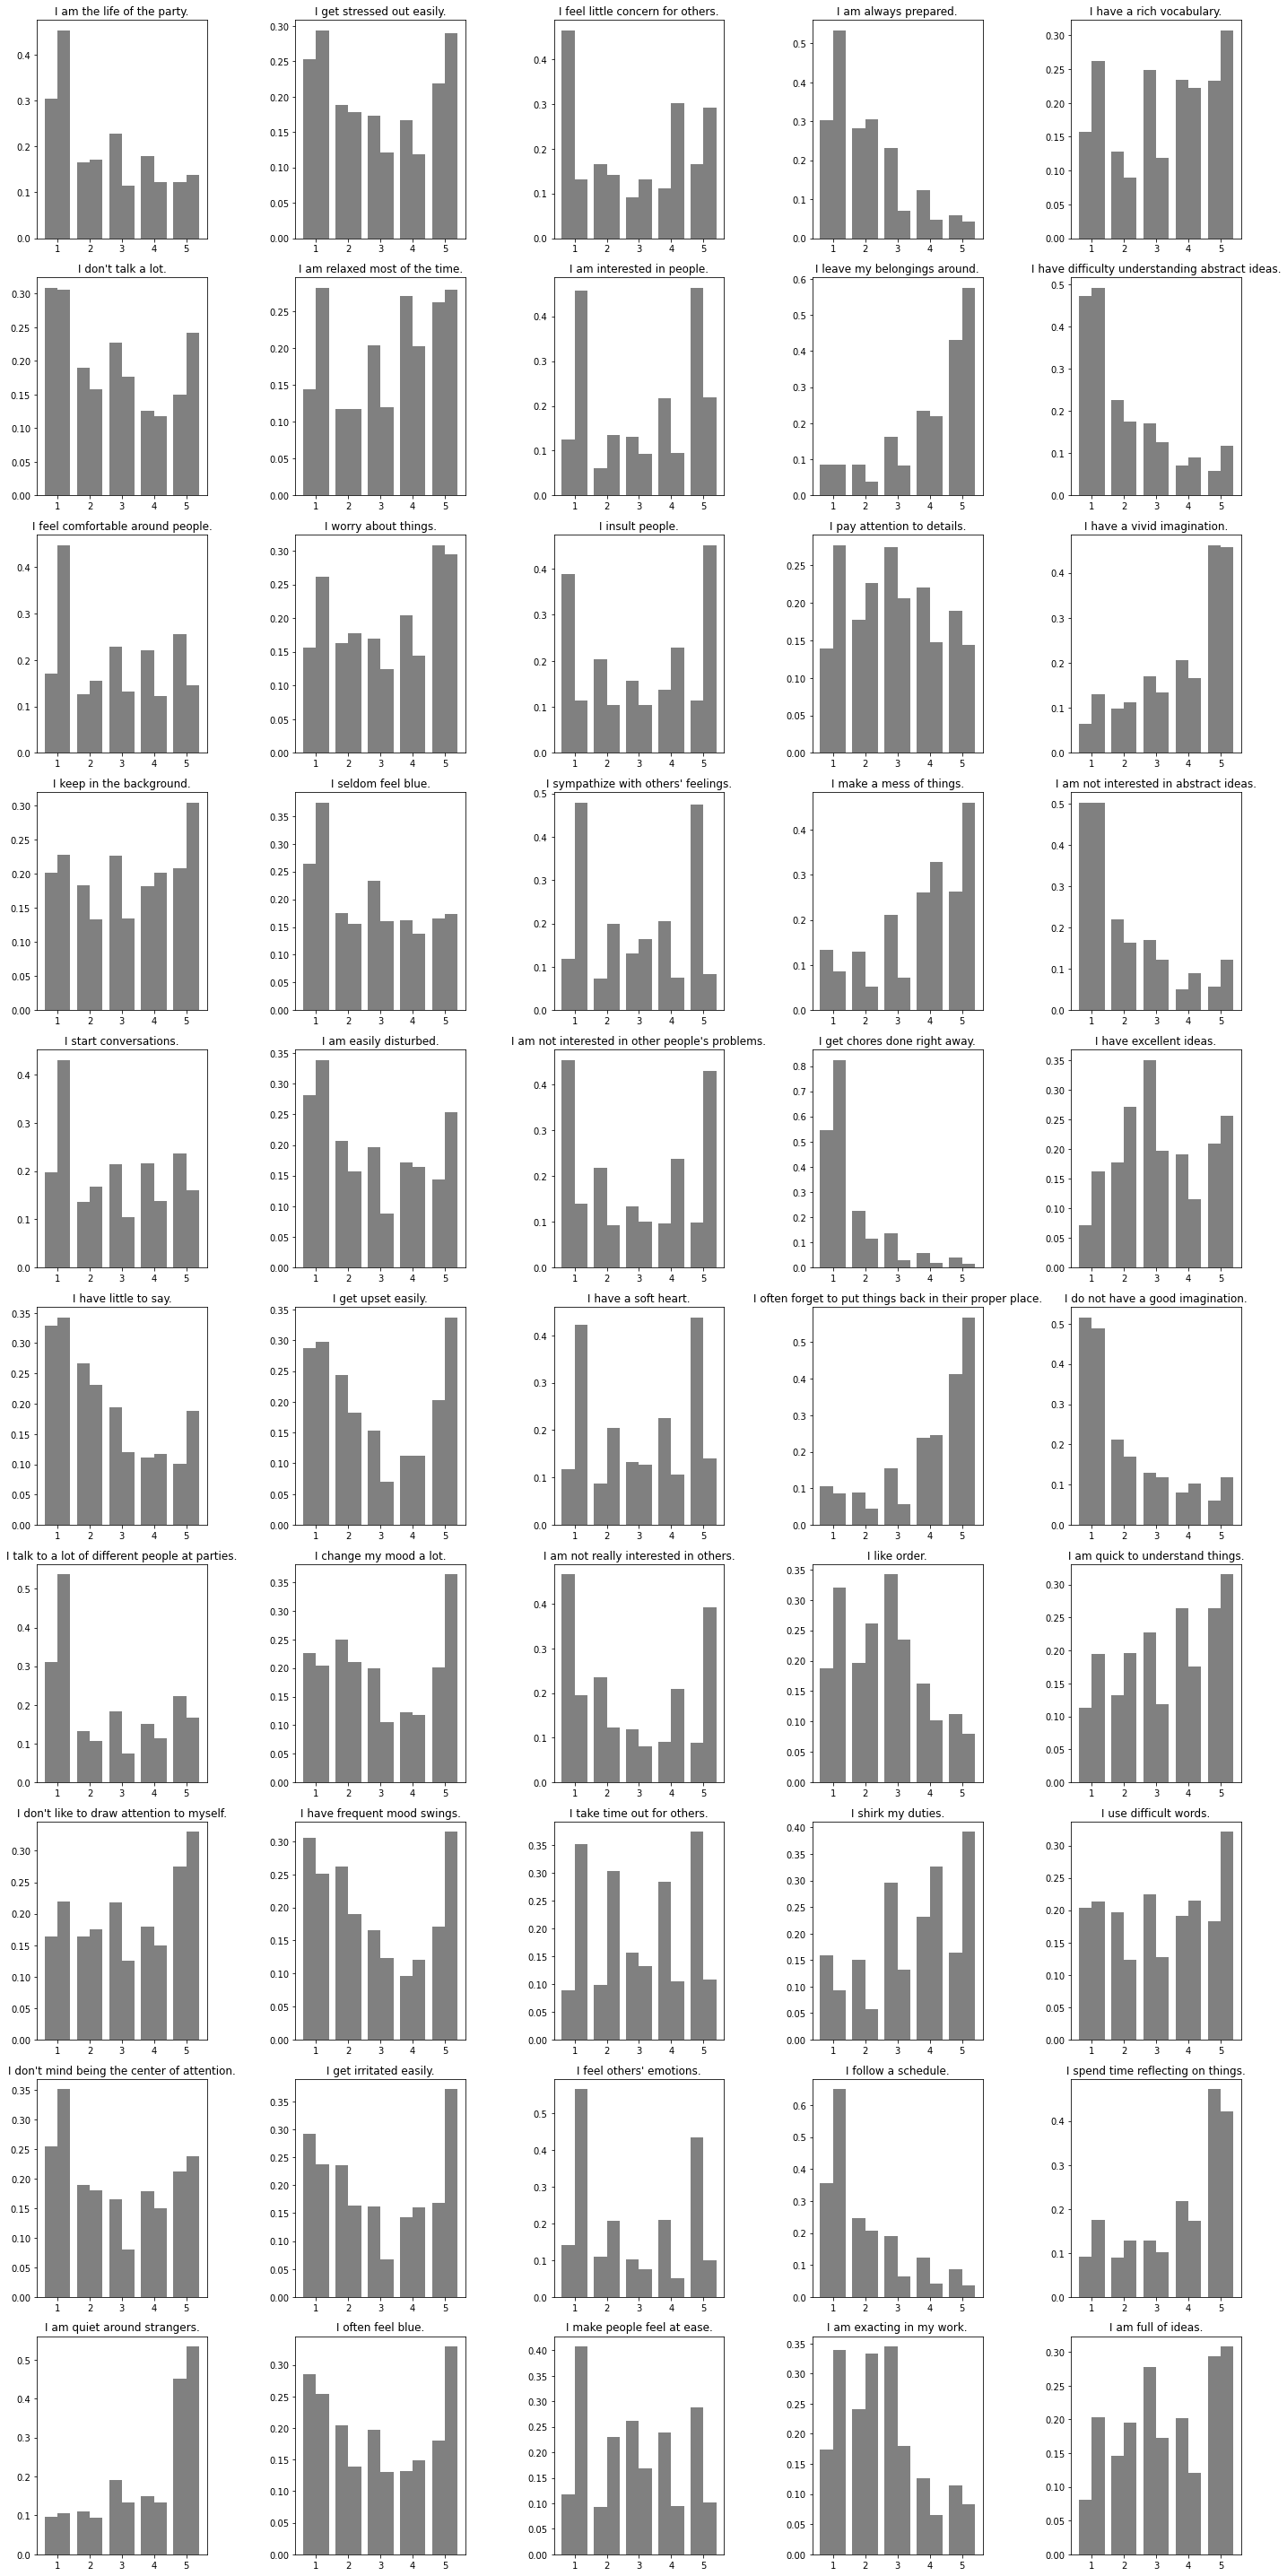

In [8]:
# Select which variable to check (intiger from 0 to 4)
VARIABLE_INDEX = 1

# What value shoud variable take in ovserved index (real value from 0 to 1.0)
VARIABLE_VALUE = 1.0

traits_observation = np.array([
    [np.nan] * 5, 
    [np.nan] * 5
])

traits_observation[0, VARIABLE_INDEX] = VARIABLE_VALUE

model.reset_observations()
model.observe_traits(traits_observation)
model.infer(1000, train=False)
samples = model.sample(5000)['anwser'].detach().numpy().reshape(-1, 5, 10, 2)

anwsers_observed = samples[:,:,:,0]
anwsers_unobserved = samples[:,:,:,1]

figs, axs = plt.subplots(10, 5, figsize=(5 * 4, 10 * 4))

import collections
for i in range(5):
    for j in range(10):
        question = list(QUESTIONS.values())[i * 10 + j]

        values_observed = collections.Counter(anwsers_observed[:, i, j] + 1)
        values_unobserved = collections.Counter(anwsers_unobserved[:, i, j] + 1)

        # normalzie
        k_obs, v_obs = normalized(values_observed)
        k_unobs, v_unobs = normalized(values_unobserved)

        axs[j][i].bar(k_obs + 0.2, v_obs, color='gray', width=0.4, align='center')
        axs[j][i].bar(k_unobs - 0.2, v_unobs, color='b', width=0.4, align='center')
        axs[j, i].set_title(question)

plt.tight_layout()
plt.show()

### Most affected anwsers for each trait
For every trait show 5 statements that diverged the most from prior to posterior on seeing a maximum value of a latent.

100%|██████████| 3000/3000 [00:17<00:00, 166.92it/s]


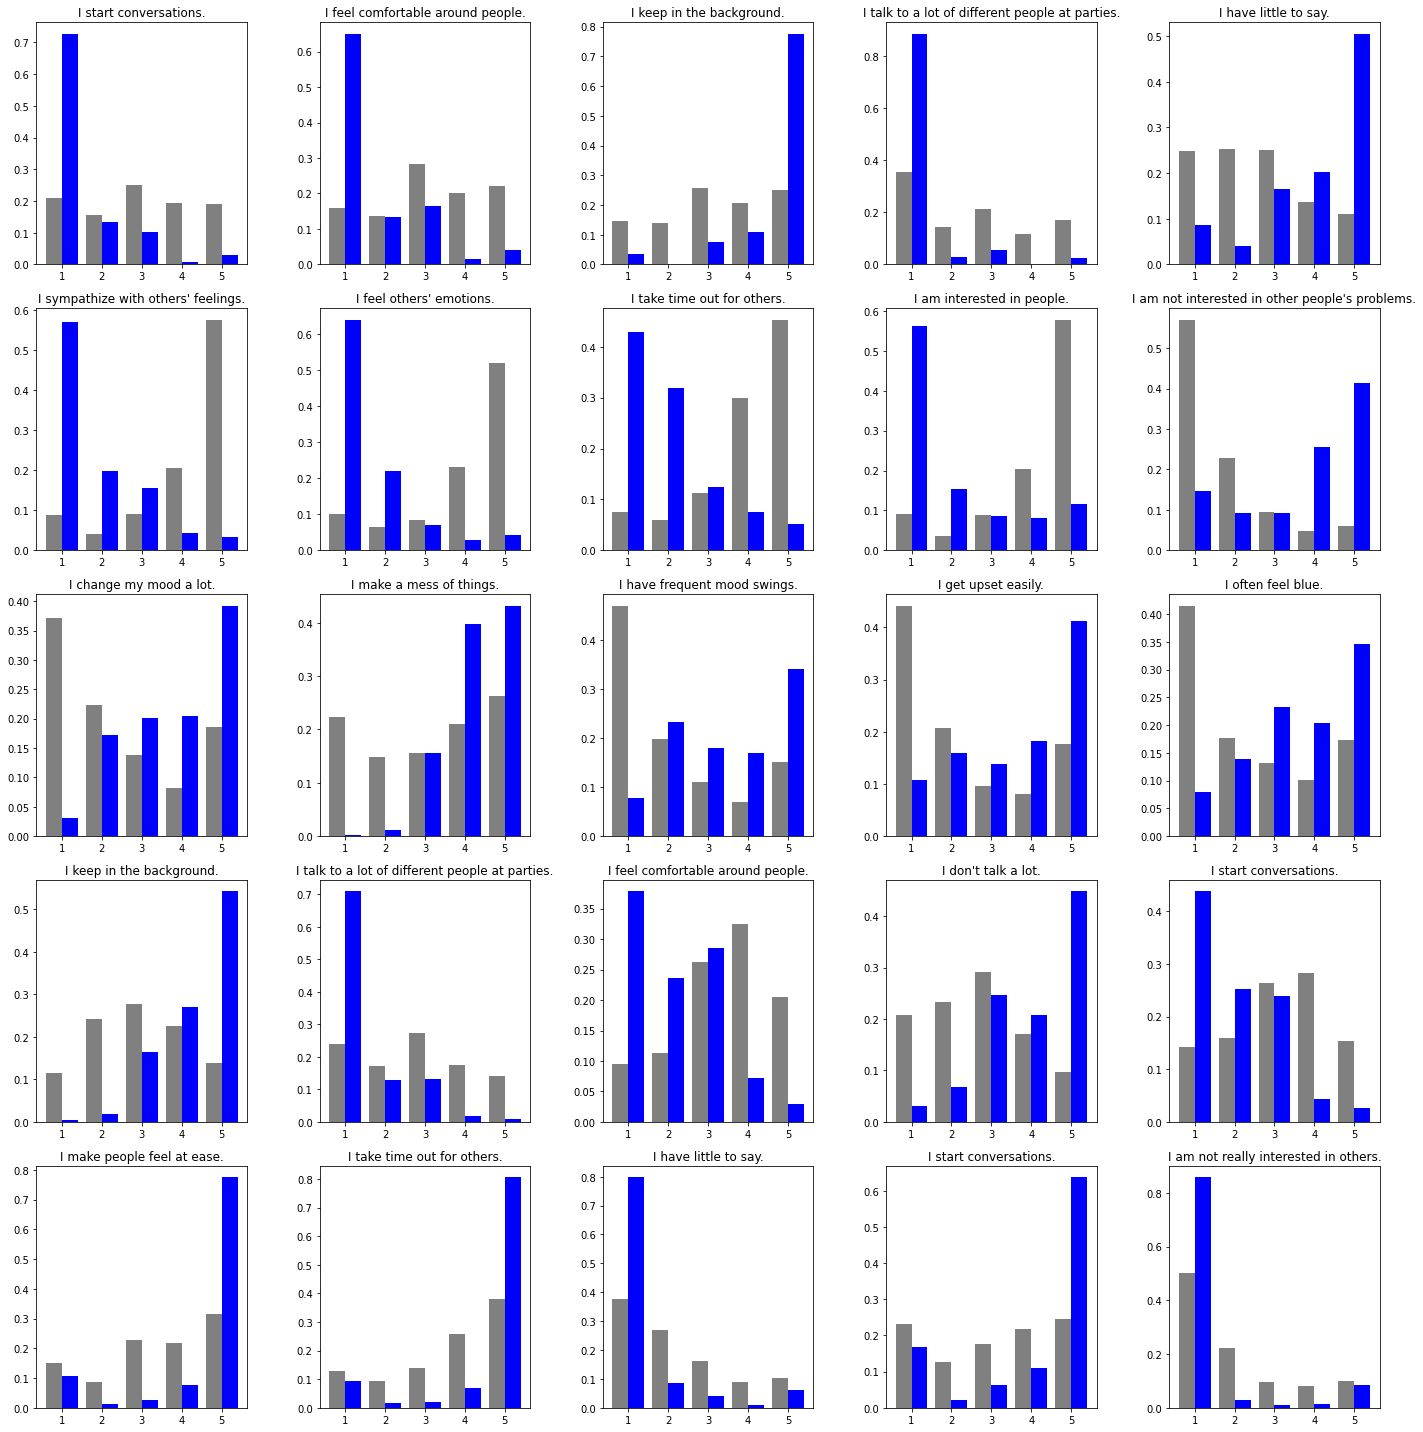

In [9]:
figs, axs = plt.subplots(5, 5, figsize=(5 * 4, 5 * 4))

trait_divergences = []
for variable_index in range(5):
    traits_observation = np.array([
        [np.nan] * 5, 
        [np.nan] * 5
    ])

    traits_observation[0, variable_index] = 1.0

    model.reset_observations()
    model.observe_traits(traits_observation)
    model.infer(3000, train=False)
    samples = model.sample(5000)['anwser'].detach().numpy().reshape(-1, 50, 2)

    anwsers_observed = samples[:,:,0]
    anwsers_unobserved = samples[:,:,1]

    divergences = []

    import collections
    for q in range(50):
        question = list(QUESTIONS.values())[q]

        values_observed = collections.Counter(anwsers_observed[:, q] + 1)
        values_unobserved = collections.Counter(anwsers_unobserved[:, q] + 1)

        # As we condition on extreme values, there is high probability
        # that some of the anwsers on 5-point scale will have 0 occurances
        # We need to add them to 
        for k in [1, 2, 3, 4, 5]:
            if k not in values_observed.keys():
                values_observed[k] = 1 # Force at least 1 occurance, just to be sure KL won't blow

        # Sort to have corresponding values (in order 1,2,3,5)
        values_observed = SortedDict(values_observed)
        values_unobserved = SortedDict(values_unobserved)

        k_obs, v_obs = normalized(values_observed)
        k_unobs, v_unobs = normalized(values_unobserved)

        # Scikit entropy with q(x) parameter actually calculates KL-Divergence
        divergence = entropy(v_obs, v_unobs)
        divergences.append((divergence, question, k_obs, v_obs, k_unobs, v_unobs))
    most_divergent = sorted(divergences, key=lambda x: x[0], reverse=True)[:5]

    trait_divergences.append(most_divergent)

for trait_i, trait in enumerate(trait_divergences):
    for q_i, q in enumerate(trait):
        divergence, question, k_obs, v_obs, k_unobs, v_unobs = q

        axs[trait_i][q_i].bar(k_obs + 0.2, v_obs, color='b', width=0.4, align='center')
        axs[trait_i][q_i].bar(k_unobs - 0.2, v_unobs, color='gray', width=0.4, align='center')
        axs[trait_i, q_i].set_title(question)

plt.tight_layout()
plt.show()

## Negative log likelihood

In [10]:
train, test = load_train_test()

In [11]:
test = test.dropna()

In [12]:
model.reset_observations()
model.log_prob(test)

100%|██████████| 3000/3000 [01:38<00:00, 30.55it/s]


array(-27409.986, dtype=float32)

## Classification

In [13]:
f1s = []

for i in range(1, 10):
    percent_missing = i * 0.1
    test_missing = test.copy(deep=True)
    test_missing = test_missing.mask(np.random.random(test_missing.shape) < percent_missing)

    reconstructed = model.predict_anwser(test_missing, 2_000)

    pred = reconstructed.iloc[:, :50].where(test_missing.isnull()).values.reshape(-1)
    real = test.iloc[:, :50].where(test_missing.isnull()).values.reshape(-1)

    real = np.clip(real[~pd.isnull(real)], 1.0, 5.0)
    pred = pred[~pd.isnull(pred)]

    f1s.append(f1_score(real, pred, average='micro'))

100%|██████████| 2000/2000 [01:32<00:00, 21.53it/s]


[Text(0, 0.5, 'Micro F1 score'), Text(0.5, 0, 'Fraction of data missing')]

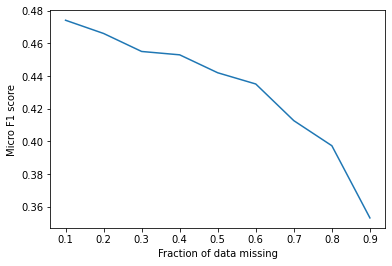

In [14]:
ax = sns.lineplot(np.array(range(1, 10)) * 0.1, y=f1s, )
ax.set(xlabel="Fraction of data missing", ylabel="Micro F1 score")